# Imports

In [10]:
import torch
import torchvision
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
import numpy as np
import os, json, random
import cv2 as cv
from matplotlib import pyplot as plt
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.utils.visualizer import ColorMode

from prepare_models import Models

import os

In [11]:
print('Is CUDA available:',torch.cuda.is_available())
print('CUDA version:',torch.version.cuda)
print('Torch.version:',torch.__version__)
print('Detectron2 version:',detectron2.__version__)

Is CUDA available: True
CUDA version: 11.3
Torch.version: 1.11.0+cu113
Detectron2 version: 0.6


In [12]:
# prepare segmentation model
predictor = Models().preapre_segmentation_model()

Model initialization
[06/07 11:02:02 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.r

In [13]:
# prepare files
PATH = r"Z:\labeled_data_060622"
image_path_list = list()
for filename in os.listdir(PATH):
    if ".png" in filename: image_path_list.append(os.path.join(PATH,filename))

print(f"Loaded {len(image_path_list)} images!")

Loaded 263 images!


In [14]:
import time

array_time_prediction = np.empty((len(image_path_list)))

for i,ImgPath in enumerate(image_path_list):
    im = cv.imread(ImgPath)
    time_start = time.time_ns()
    predictions = predictor(im)
    time_prediction = (time.time_ns()-time_start)/1e6 # miliseconds
    array_time_prediction[i] = time_prediction
    print(f"{i+1}/{len(image_path_list)}, time: {time_prediction}")

1/263, time: 243.8788
2/263, time: 228.2818
3/263, time: 232.6146
4/263, time: 213.6948
5/263, time: 241.2464
6/263, time: 255.1628
7/263, time: 255.297
8/263, time: 260.0343
9/263, time: 260.7565
10/263, time: 264.0538
11/263, time: 288.7708
12/263, time: 289.4659
13/263, time: 252.1702
14/263, time: 264.8636
15/263, time: 259.5247
16/263, time: 262.8726
17/263, time: 253.7057
18/263, time: 238.7736
19/263, time: 235.6192
20/263, time: 226.0564
21/263, time: 244.6717
22/263, time: 274.1449
23/263, time: 241.2533
24/263, time: 265.3323
25/263, time: 264.9006
26/263, time: 286.4858
27/263, time: 242.7915
28/263, time: 241.7952
29/263, time: 238.5194
30/263, time: 242.7646
31/263, time: 217.4486
32/263, time: 251.9491
33/263, time: 247.0751
34/263, time: 274.9049
35/263, time: 276.8635
36/263, time: 260.6122
37/263, time: 287.405
38/263, time: 283.4782
39/263, time: 207.3735
40/263, time: 260.5521
41/263, time: 245.9245
42/263, time: 244.6422
43/263, time: 244.5691
44/263, time: 247.4734


Device used: NVIDIA GeForce GTX 1060 6GB;

Mean time of prediciton: 252.561+-44.439 ms;

Max time: 300.851 ms for img: Z:\labeled_data_060622\_13_47.png;

Min time: 193.952 ms for img: Z:\labeled_data_060622\_4_16.png;




c:\Users\KacperMarciniak\anaconda3\envs\env_main\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
c:\Users\KacperMarciniak\anaconda3\envs\env_main\lib\site-packages\ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


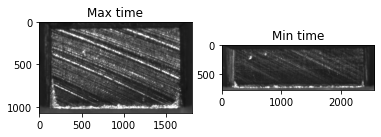

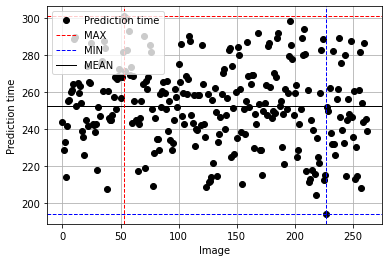

In [15]:
mean_time = array_time_prediction.mean()
std_time = array_time_prediction.std()
max_time = (np.max(array_time_prediction),np.argmax(array_time_prediction))
min_time = (np.min(array_time_prediction),np.argmin(array_time_prediction))

if torch.cuda.is_available(): 
    device = torch.cuda.get_device_name(torch.cuda.current_device())
else:
    device = "CPU"

print(f'''
Device used: {device};\n
Mean time of prediciton: {mean_time:.3f}+-{2*std_time:.3f} ms;\n
Max time: {max_time[0]:.3f} ms for img: {image_path_list[max_time[1]]};\n
Min time: {min_time[0]:.3f} ms for img: {image_path_list[min_time[1]]};\n
''')
fig,axes = plt.subplots(ncols=2)
axes[0].imshow(cv.imread(image_path_list[max_time[1]]))
axes[0].set_title("Max time")
axes[1].imshow(cv.imread(image_path_list[min_time[1]]))
axes[1].set_title("Min time")
fig.show()
fig,ax = plt.subplots(ncols=1)
ax.plot(
    array_time_prediction, 
    linestyle="none", marker="o", label="Prediction time", color="black"
)
ax.axhline(max_time[0], label="MAX", color="red", linestyle="--", linewidth=1)
ax.axhline(min_time[0], label="MIN", color="blue", linestyle="--", linewidth=1)
ax.axhline(mean_time, label="MEAN", color="black", linestyle="-", linewidth=1)
ax.axvline(max_time[1], color="red", linestyle="--", linewidth=1)
ax.axvline(min_time[1], color="blue", linestyle="--", linewidth=1)
ax.grid(True)
ax.legend(loc="upper left")
ax.set_xlabel("Image")
ax.set_ylabel("Prediction time")
fig.show()